In [1]:
# !pip install pandas matplotlib numpy

In [64]:
import os
from pathlib import Path
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from plotter import *
from plotter.epochstats import EpochStats
from plotter.plotepochstats import PlotRangeQueryStats, PlotEpochStats, plot_total_data_movement
from plotter.plotselectivities import PlotSelectivities, PlotSelectivitiesRangeQuery
from plotter.utils import vanilla_dirname, rqdc_dirname
from plotter.dataclass import TABLE_DATA, Metric, Approach

prop = font_manager.FontProperties(fname="./plotter/LinLibertine_Mah.ttf")
plt.rcParams['font.family'] = prop.get_name()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.weight'] = 'bold'

PROJECT_DIR = Path.cwd().parent.parent
SELECTIVITIES = (0.1, 0.05, 0.01, 0.001, "0.0001", "0.00001")
SELECTIVITIES = SELECTIVITIES[::-1]

In [65]:
avg_file_size = {}
avg_files_count = {}
range_query_avg_read_bytes = {}

for selectivity in SELECTIVITIES:
    avg_file_size[selectivity] = {}
    avg_files_count[selectivity] = {}
    range_query_avg_read_bytes[selectivity] = {}
    lb = 1 / SIZE_RATIO
    EXPDIRNAME = f"{PROJECT_DIR}/.vstats/experiments-{TAG}-U{UPDATES}-E{ENTRY_SIZE}-B{ENTRIES_PER_PAGE}-P{NUM_PAGE_PER_FILE}-S{RANGE_QUERIES}-Y{selectivity}-T{SIZE_RATIO}"

    rocksdb_dirpath = os.path.join(EXPDIRNAME, "RocksDB")
    rocksdb_tuned_dirpath = os.path.join(EXPDIRNAME, "RocksDBTuned")
    rr_lb0_smlck0_dirpath = os.path.join(EXPDIRNAME, "RangeReduce[lb=0ANDsmlck=0]")
    rr_lb0_dirpath = os.path.join(EXPDIRNAME, "RangeReduce[lb=0]")
    # rr_lb_1_by_T_dirpath = os.path.join(EXPDIRNAME, "RangeReduce[lb=T^-1]")
    # rr_lb_1_by_T_and_re_1_dirpath = os.path.join(EXPDIRNAME, "RangeReduce[lb=T^-1ANDre=1]")

    filesize = ENTRY_SIZE * ENTRIES_PER_PAGE * NUM_PAGE_PER_FILE

    rocksdb = EpochStats(rocksdb_dirpath, NUMEPOCHS, filesize)
    rocksdb_tuned = EpochStats(rocksdb_tuned_dirpath, NUMEPOCHS, filesize)
    rr_lb_0_smlck_0 = EpochStats(rr_lb0_smlck0_dirpath, NUMEPOCHS, filesize)
    rr_lb_0 = EpochStats(rr_lb0_dirpath, NUMEPOCHS, filesize)
    # rr_lb_1_by_T = EpochStats(rr_lb_1_by_T_dirpath, NUMEPOCHS, filesize)
    # rr_lb_1_by_T_and_re_1 = EpochStats(rr_lb_1_by_T_and_re_1_dirpath, NUMEPOCHS, filesize)

    plot_exp = PlotRangeQueryStats(
        {
            "RocksDB": rocksdb.get_rangequerystats(),
            "RocksDBTuned": rocksdb_tuned.get_rangequerystats(),
            "RangeReduce[lb=0 & smlck=0]": rr_lb_0_smlck_0.get_rangequerystats(),
            "RangeReduce[lb=0]": rr_lb_0.get_rangequerystats(),
            # "RangeReduce[lb=T^-1]": rr_lb_1_by_T.get_rangequerystats(),
            # "RangeReduce[lb=T^-1 & re=1]": rr_lb_1_by_T_and_re_1.get_rangequerystats(),
        }
    )
    plot_exp.bytes_read_for_each_range_query()
    # plot_exp.latency_for_each_range_query()
    # plot_exp.cummulative_latency_for_range_queries()

    metric_exp = PlotEpochStats(
        {
            "RocksDB": rocksdb.get_plotstats(),
            "RocksDBTuned": rocksdb_tuned.get_plotstats(),
            "RangeReduce[lb=0 & smlck=0]": rr_lb_0_smlck_0.get_plotstats(),
            "RangeReduce[lb=0]": rr_lb_0.get_plotstats(),
            # "RangeReduce[lb=T^-1]": rr_lb_1_by_T.get_plotstats(),
            # "RangeReduce[lb=T^-1 & re=1]": rr_lb_1_by_T_and_re_1.get_plotstats(),
        }
    )
    # metric_exp.plot_total_bytes_written()
    # metric_exp.plot_database_size()
    # metric_exp.plot_compaction_debt()
    metric_exp.plot_space_amplification()
    # metric_exp.plot_compaction_read()
    # metric_exp.plot_workload_exec_time()
    # plot_total_data_movement(
    #     {
    #         "RocksDB": rocksdb.get_plotstats(),
    #         "RocksDBTuned": rocksdb_tuned.get_plotstats(),
    #         "RangeReduce[lb=0 & smlck=0]": rr_lb_0_smlck_0.get_plotstats(),
    #         "RangeReduce[lb=0]": rr_lb_0.get_plotstats(),
    #         # "RangeReduce[lb=T^-1]": rr_lb_1_by_T.get_plotstats(),
    #         # "RangeReduce[lb=T^-1 & re=1]": rr_lb_1_by_T_and_re_1.get_plotstats(),
    #     },
    #     {
    #         "RocksDB": rocksdb.get_rangequerystats(),
    #         "RocksDBTuned": rocksdb_tuned.get_rangequerystats(),
    #         "RangeReduce[lb=0 & smlck=0]": rr_lb_0_smlck_0.get_rangequerystats(),
    #         "RangeReduce[lb=0]": rr_lb_0.get_rangequerystats(),
    #         # "RangeReduce[lb=T^-1]": rr_lb_1_by_T.get_rangequerystats(),
    #         # "RangeReduce[lb=T^-1 & re=1]": rr_lb_1_by_T_and_re_1.get_rangequerystats(),
    #     },
    # )

    method_mapping = {
        "RocksDB": "RocksDB",
        "RocksDBTuned": "RocksDBTuned",
        "RangeReduce[lb=0 & smlck=0]": "MergeOnScan",
        "RangeReduce[lb=0]": "FileSizeAwareMergeOnScan",
        "RangeReduce[lb=T^-1]": "BoundedMerge",
        "RangeReduce[lb=T^-1 & re=1]": "RangeReduce[level renaming & bounded merge]",
    }
    rows = []
    ordered_columns = ["Method"] + [metric.value[0] for metric in Metric]

    for method, metrics in TABLE_DATA.items():
        row = {"Method": method_mapping[method]}
        row.update(metrics)
        rows.append(row)

        if method in [str(Approach.ROCKSDB), str(Approach.ROCKSDB_TUNED), str(Approach.RANGE_REDUCE_LB_0_AND_SMLCK_0), str(Approach.RANGE_REDUCE_LB_0)]:
            avg_file_size[selectivity][method_mapping[method]] = metrics[str(Metric.AVG_FILE_SIZE)]
            avg_files_count[selectivity][method_mapping[method]] = metrics[str(Metric.TOTAL_FILES_COUNT)]
            range_query_avg_read_bytes[selectivity][method_mapping[method]] = metrics[str(Metric.AVG_BYTES_READ_RQ)]

    ordered_rows = []
    for row in rows:
        ordered_row = {col: row.get(col, "") for col in ordered_columns}
        ordered_rows.append(ordered_row)

    markdown_table = tabulate(ordered_rows, headers="keys", tablefmt="github")
    print(markdown_table)

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2000x400 with 1 Axes>

/home/cc/LSMQueryDrivenCompaction/src/.notebooks/plotter/plotepochstats.py:142: RuntimeWarning: invalid value encountered in scalar divide
  avg_bytes_written_by_RR[approach] = [plot_stat[0].RangeReduceWrittenBytes / (TABLE_DATA[approach][str(Metric.RR_TRIGGERED_COUNT)] * 1024**2)]


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 700x500 with 1 Axes>

| Method                                      | tot. writes (GB)   | s. amp.   | comp. debt. (MB)   | RQ lat. (avg ms)   | overall data mov. (GB)   | w/l exec. time (sec)   | # RR trig   | avg. fsize         | tot. fcount   | avg. bytes read RQ (MB)   | avg. bytes written RR (MB)   | tot. comp. read (Not RR) (GB)   | tail RQ lat. 98   | tail RQ lat. 100   |
|---------------------------------------------|--------------------|-----------|--------------------|--------------------|--------------------------|------------------------|-------------|--------------------|---------------|---------------------------|------------------------------|---------------------------------|-------------------|--------------------|
| RocksDB                                     |                    | 1.47      |                    |                    |                          |                        | 0           | 3.689548682229232  | 407           | 0.012426350911458333      | nan                       

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2000x400 with 1 Axes>

/home/cc/LSMQueryDrivenCompaction/src/.notebooks/plotter/plotepochstats.py:142: RuntimeWarning: invalid value encountered in scalar divide
  avg_bytes_written_by_RR[approach] = [plot_stat[0].RangeReduceWrittenBytes / (TABLE_DATA[approach][str(Metric.RR_TRIGGERED_COUNT)] * 1024**2)]


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 700x500 with 1 Axes>

| Method                                      | tot. writes (GB)   | s. amp.   | comp. debt. (MB)   | RQ lat. (avg ms)   | overall data mov. (GB)   | w/l exec. time (sec)   | # RR trig   | avg. fsize         | tot. fcount   | avg. bytes read RQ (MB)   | avg. bytes written RR (MB)   | tot. comp. read (Not RR) (GB)   | tail RQ lat. 98   | tail RQ lat. 100   |
|---------------------------------------------|--------------------|-----------|--------------------|--------------------|--------------------------|------------------------|-------------|--------------------|---------------|---------------------------|------------------------------|---------------------------------|-------------------|--------------------|
| RocksDB                                     |                    | 1.46      |                    |                    |                          |                        | 0           | 3.7115103854468807 | 402           | 0.12454169379340278       | nan                       

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2000x400 with 1 Axes>

/home/cc/LSMQueryDrivenCompaction/src/.notebooks/plotter/plotepochstats.py:142: RuntimeWarning: invalid value encountered in scalar divide
  avg_bytes_written_by_RR[approach] = [plot_stat[0].RangeReduceWrittenBytes / (TABLE_DATA[approach][str(Metric.RR_TRIGGERED_COUNT)] * 1024**2)]


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 700x500 with 1 Axes>

| Method                                      | tot. writes (GB)   | s. amp.   | comp. debt. (MB)   | RQ lat. (avg ms)   | overall data mov. (GB)   | w/l exec. time (sec)   | # RR trig   | avg. fsize         | tot. fcount   | avg. bytes read RQ (MB)   | avg. bytes written RR (MB)   | tot. comp. read (Not RR) (GB)   | tail RQ lat. 98   | tail RQ lat. 100   |
|---------------------------------------------|--------------------|-----------|--------------------|--------------------|--------------------------|------------------------|-------------|--------------------|---------------|---------------------------|------------------------------|---------------------------------|-------------------|--------------------|
| RocksDB                                     |                    | 1.46      |                    |                    |                          |                        | 0           | 3.6989857339977332 | 403           | 1.2437973361545138        | nan                       

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2000x400 with 1 Axes>

/home/cc/LSMQueryDrivenCompaction/src/.notebooks/plotter/plotepochstats.py:142: RuntimeWarning: invalid value encountered in scalar divide
  avg_bytes_written_by_RR[approach] = [plot_stat[0].RangeReduceWrittenBytes / (TABLE_DATA[approach][str(Metric.RR_TRIGGERED_COUNT)] * 1024**2)]


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 700x500 with 1 Axes>

| Method                                      | tot. writes (GB)   | s. amp.   | comp. debt. (MB)   | RQ lat. (avg ms)   | overall data mov. (GB)   | w/l exec. time (sec)   | # RR trig   | avg. fsize         | tot. fcount   | avg. bytes read RQ (MB)   | avg. bytes written RR (MB)   | tot. comp. read (Not RR) (GB)   | tail RQ lat. 98   | tail RQ lat. 100   |
|---------------------------------------------|--------------------|-----------|--------------------|--------------------|--------------------------|------------------------|-------------|--------------------|---------------|---------------------------|------------------------------|---------------------------------|-------------------|--------------------|
| RocksDB                                     |                    | 1.45      |                    |                    |                          |                        | 0           | 3.734006232352712  | 398           | 12.438158501519098        | nan                       

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2000x400 with 1 Axes>

/home/cc/LSMQueryDrivenCompaction/src/.notebooks/plotter/plotepochstats.py:142: RuntimeWarning: invalid value encountered in scalar divide
  avg_bytes_written_by_RR[approach] = [plot_stat[0].RangeReduceWrittenBytes / (TABLE_DATA[approach][str(Metric.RR_TRIGGERED_COUNT)] * 1024**2)]


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 700x500 with 1 Axes>

| Method                                      | tot. writes (GB)   | s. amp.   | comp. debt. (MB)   | RQ lat. (avg ms)   | overall data mov. (GB)   | w/l exec. time (sec)   | # RR trig   | avg. fsize        | tot. fcount   | avg. bytes read RQ (MB)   | avg. bytes written RR (MB)   | tot. comp. read (Not RR) (GB)   | tail RQ lat. 98   | tail RQ lat. 100   |
|---------------------------------------------|--------------------|-----------|--------------------|--------------------|--------------------------|------------------------|-------------|-------------------|---------------|---------------------------|------------------------------|---------------------------------|-------------------|--------------------|
| RocksDB                                     |                    | 1.46      |                    |                    |                          |                        | 0           | 3.695708473130028 | 404           | 62.031391330295136        | nan                          

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2000x400 with 1 Axes>

/home/cc/LSMQueryDrivenCompaction/src/.notebooks/plotter/plotepochstats.py:142: RuntimeWarning: invalid value encountered in scalar divide
  avg_bytes_written_by_RR[approach] = [plot_stat[0].RangeReduceWrittenBytes / (TABLE_DATA[approach][str(Metric.RR_TRIGGERED_COUNT)] * 1024**2)]


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 700x500 with 1 Axes>

| Method                                      | tot. writes (GB)   | s. amp.   | comp. debt. (MB)   | RQ lat. (avg ms)   | overall data mov. (GB)   | w/l exec. time (sec)   | # RR trig   | avg. fsize         | tot. fcount   | avg. bytes read RQ (MB)   | avg. bytes written RR (MB)   | tot. comp. read (Not RR) (GB)   | tail RQ lat. 98   | tail RQ lat. 100   |
|---------------------------------------------|--------------------|-----------|--------------------|--------------------|--------------------------|------------------------|-------------|--------------------|---------------|---------------------------|------------------------------|---------------------------------|-------------------|--------------------|
| RocksDB                                     |                    | 1.46      |                    |                    |                          |                        | 0           | 3.668420693212411  | 407           | 123.80093478732638        | nan                       

In [26]:
avg_files_count

{'0.00001': {'RocksDB': 407,
  'RocksDBTuned': 407,
  'MergeOnScan': 502,
  'FileSizeAwareMergeOnScan': 408},
 '0.0001': {'RocksDB': 402,
  'RocksDBTuned': 399,
  'MergeOnScan': 525,
  'FileSizeAwareMergeOnScan': 402},
 0.001: {'RocksDB': 403,
  'RocksDBTuned': 407,
  'MergeOnScan': 480,
  'FileSizeAwareMergeOnScan': 403},
 0.01: {'RocksDB': 398,
  'RocksDBTuned': 398,
  'MergeOnScan': 364,
  'FileSizeAwareMergeOnScan': 376},
 0.05: {'RocksDB': 404,
  'RocksDBTuned': 405,
  'MergeOnScan': 294,
  'FileSizeAwareMergeOnScan': 295},
 0.1: {'RocksDB': 407,
  'RocksDBTuned': 409,
  'MergeOnScan': 290,
  'FileSizeAwareMergeOnScan': 290}}

In [6]:
range_query_avg_read_bytes

{0.1: {'RocksDB': 123.80093478732638,
  'RocksDBTuned': 124.29288113064236,
  'MergeOnScan': 103.78605550130209,
  'FileSizeAwareMergeOnScan': 104.14213690863716},
 0.05: {'RocksDB': 62.031391330295136,
  'RocksDBTuned': 62.49326565212674,
  'MergeOnScan': 52.3795166015625,
  'FileSizeAwareMergeOnScan': 52.898070882161456},
 0.01: {'RocksDB': 12.438158501519098,
  'RocksDBTuned': 12.500313178168403,
  'MergeOnScan': 11.156446261935764,
  'FileSizeAwareMergeOnScan': 11.822599690755208},
 0.001: {'RocksDB': 1.2437973361545138,
  'RocksDBTuned': 1.245110134548611,
  'MergeOnScan': 1.21814453125,
  'FileSizeAwareMergeOnScan': 1.2562234157986112},
 '0.0001': {'RocksDB': 0.12454169379340278,
  'RocksDBTuned': 0.12474392361111111,
  'MergeOnScan': 0.12423624674479167,
  'FileSizeAwareMergeOnScan': 0.1255678982204861},
 '0.00001': {'RocksDB': 0.012426350911458333,
  'RocksDBTuned': 0.01230712890625,
  'MergeOnScan': 0.012360161675347222,
  'FileSizeAwareMergeOnScan': 0.01235934787326389}}

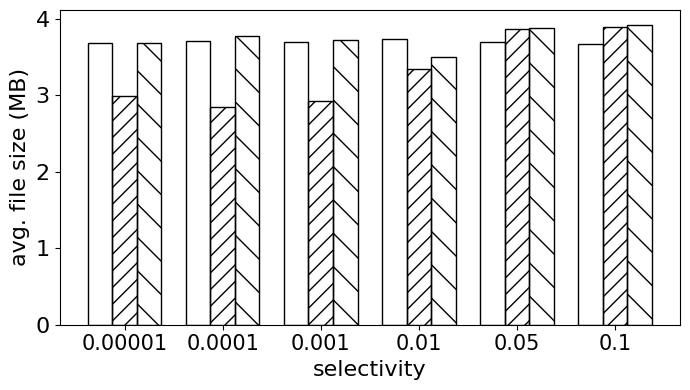

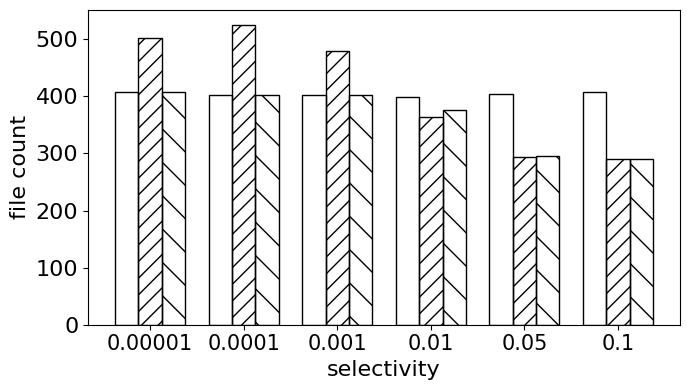

<Figure size 800x200 with 0 Axes>

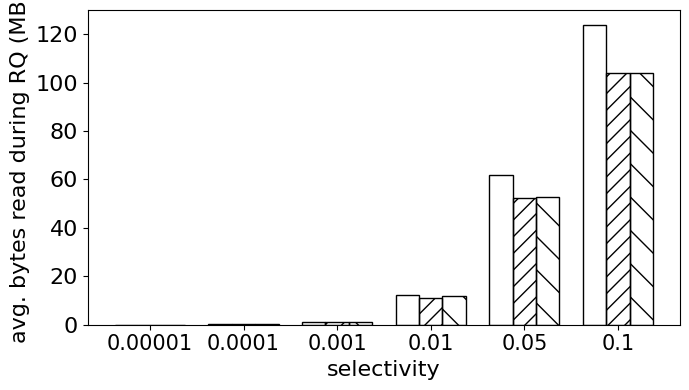

In [62]:
fig_size = (7, 4)
rocksdb_bar_kwargs = {
    "label": "RocksDB",
    "color": "None",
    "hatch": "",
    "edgecolor": "black",
}
rocksdbTuned_bar_kwargs = {
    "label": "RocksDBTuned",
    "color": "None",
    "hatch": "--",
    "edgecolor": "black",
}
mergeonscan_bar_kwargs = {
    "label": "MergeOnScan",
    "color": "None",
    "hatch": "//",
    "edgecolor": "black",
}
fileawaremergeonscan_bar_kwargs = {
    "label": "FileSizeAwareMergeOnScan",
    "color": "None",
    "hatch": "\\",
    "edgecolor": "black",
}


def plot_avg_files_sizes():
    x = np.arange(len(SELECTIVITIES))
    width = 0.25
    x_points = range(len(SELECTIVITIES))
    fig, ax = plt.subplots(figsize=fig_size)
    RocksDB = [item['RocksDB'] for _, item in avg_file_size.items()]
    RocksDBTuned = [item['RocksDBTuned'] for _, item in avg_file_size.items()]
    MergeOnScan = [item['MergeOnScan'] for _, item in avg_file_size.items()]
    FileSizeAwareMergeOnScan = [item['FileSizeAwareMergeOnScan'] for _, item in avg_file_size.items()]
    ax.bar(x - width, RocksDB, width, **rocksdb_bar_kwargs)
    # ax.bar(x - 0.5 * width, RocksDBTuned, width, **rocksdbTuned_bar_kwargs)
    ax.bar(x + width, FileSizeAwareMergeOnScan, width, **fileawaremergeonscan_bar_kwargs)
    ax.bar(x, MergeOnScan, width, **mergeonscan_bar_kwargs)

    ax.set_ylabel("avg. file size (MB)", fontsize=16)
    ax.set_xlabel("selectivity", fontsize=16)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis='y', labelsize=16)

    ax.set_xticks(x_points)
    ax.set_xticklabels([f"{per}" for per in SELECTIVITIES], fontsize=15)

    # fig.legend(
    #     loc="lower center",
    #     fontsize=16,
    #     ncol=2,
    #     frameon=False,
    #     bbox_to_anchor=(0.5, 0.85),
    #     columnspacing=0.1,
    # )
    # plt.show()
    plt.tight_layout()
    plt.savefig('avg-files-size.pdf')

def plot_files_count():
    x = np.arange(len(SELECTIVITIES))
    width = 0.25
    x_points = range(len(SELECTIVITIES))
    fig, ax = plt.subplots(figsize=fig_size)
    RocksDB = [item['RocksDB'] for _, item in avg_files_count.items()]
    RocksDBTuned = [item['RocksDBTuned'] for _, item in avg_files_count.items()]
    MergeOnScan = [item['MergeOnScan'] for _, item in avg_files_count.items()]
    FileSizeAwareMergeOnScan = [item['FileSizeAwareMergeOnScan'] for _, item in avg_files_count.items()]
    ax.bar(x - width, RocksDB, width, **rocksdb_bar_kwargs)
    # ax.bar(x - 0.5 * width, RocksDBTuned, width, **rocksdbTuned_bar_kwargs)
    ax.bar(x + width, FileSizeAwareMergeOnScan, width, **fileawaremergeonscan_bar_kwargs)
    ax.bar(x, MergeOnScan, width, **mergeonscan_bar_kwargs)

    ax.set_ylabel("file count", fontsize=16)
    ax.set_xlabel("selectivity", fontsize=16)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis='y', labelsize=16)

    ax.set_xticks(x_points)
    ax.set_xticklabels([f"{per}" for per in SELECTIVITIES], fontsize=15)

    # fig.legend(
    #     loc="lower center",
    #     fontsize=16,
    #     ncol=2,
    #     frameon=False,
    #     bbox_to_anchor=(0.5, 0.85),
    #     columnspacing=0.1,
    # )
    # plt.show()
    plt.tight_layout()
    plt.savefig('avg-files-count.pdf')

    # Create a separate figure for the legend
    # Retrieve handles and labels from the existing axes
    handles, labels = ax.get_legend_handles_labels()
    
    # Create a new figure solely for the legend
    legend_fig = plt.figure(figsize=(8, 2))
    # Add legend to the new figure (centered, with 2 columns and desired spacing)
    legend_fig.legend(handles, labels, loc="center", ncol=3, frameon=False, fontsize=16)
    
    # Save the legend figure separately; bbox_inches='tight' helps crop extra whitespace.
    legend_fig.savefig('legend.pdf', bbox_inches='tight')

def avg_range_query_reads():
    x = np.arange(len(SELECTIVITIES))
    width = 0.25
    x_points = range(len(SELECTIVITIES))
    fig, ax = plt.subplots(figsize=fig_size)
    RocksDB = [item['RocksDB'] for _, item in range_query_avg_read_bytes.items()]
    RocksDBTuned = [item['RocksDBTuned'] for _, item in range_query_avg_read_bytes.items()]
    MergeOnScan = [item['MergeOnScan'] for _, item in range_query_avg_read_bytes.items()]
    FileSizeAwareMergeOnScan = [item['FileSizeAwareMergeOnScan'] for _, item in range_query_avg_read_bytes.items()]
    ax.bar(x - width, RocksDB, width, **rocksdb_bar_kwargs)
    # ax.bar(x - 0.5 * width, RocksDBTuned, width, **rocksdbTuned_bar_kwargs)
    ax.bar(x + width, FileSizeAwareMergeOnScan, width, **fileawaremergeonscan_bar_kwargs)
    ax.bar(x, MergeOnScan, width, **mergeonscan_bar_kwargs)

    ax.set_ylabel("avg. bytes read during RQ (MB)", fontsize=16)
    ax.set_xlabel("selectivity", fontsize=16)
    ax.set_ylim(bottom=0)
    ax.tick_params(axis='y', labelsize=16)

    ax.set_xticks(x_points)
    ax.set_xticklabels([f"{per}" for per in SELECTIVITIES], fontsize=15)

    # fig.legend(
    #     loc="lower center",
    #     fontsize=16,
    #     ncol=2,
    #     frameon=False,
    #     bbox_to_anchor=(0.5, 0.92),
    #     columnspacing=0.1,
    # )
    # plt.show()
    plt.tight_layout()
    plt.savefig('avg-bytes-read-per-rq.pdf')

plot_avg_files_sizes()
plot_files_count()
avg_range_query_reads()